In [5]:


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import jax
import jax.numpy as jnp

from tools import BlindColours, zero_balanced_weights
from qqt_lambda_balanced import QQT_lambda_balanced
# from balanced_weights import balanced_weights
# from empiricalTest import LinearNetwork, get_random_regression_task
from linear_network import LinearNetwork 
from utils import get_random_regression_task, get_lambda_balanced


In [3]:
bc = BlindColours()
blind_colours = bc.get_colours()
div_cmap = bc.get_div_cmap()

In [6]:
np.random.seed(1)

in_dim = 8
hidden_dim = 8 
out_dim = 8

learning_rate = 0.01
training_steps = 20000

X = np.eye(8)
Y = np.asarray([
            [1.,  1.,  1., -0.,  1., -0., -0., -0.],
            [1.,  1.,  1., -0., -1., -0., -0., -0.],
            [1.,  1., -1., -0., -0.,  1., -0., -0.],
            [1.,  1., -1., -0., -0., -1., -0., -0.],
            [1., -1., -0.,  1., -0., -0.,  1., -0.],
            [1., -1., -0.,  1., -0., -0., -1., -0.],
            [1., -1., -0., -1., -0., -0., -0.,  1.],
            [1., -1., -0., -1., -0., -0., -0., -1.]
        ])



ws = dict()


w1w1s = dict()


w2w2s = dict()


losses = dict()

sigma_small = 0.001
sigma_big = 0.42

initial_weight_pairs = {}

init_w1_gaussian_small = np.random.normal(loc=0.0, scale = sigma_small, size=(hidden_dim, in_dim))
init_w2_gaussian_small = np.random.normal(loc=0.0, scale = sigma_small, size=(out_dim, hidden_dim))
initial_weight_pairs['Gaussian Small'] = (init_w1_gaussian_small, init_w2_gaussian_small)

init_w1_gaussian_large = np.random.normal(loc=0.0, scale =  sigma_big, size=(hidden_dim, in_dim))
init_w2_gaussian_large = np.random.normal(loc=0.0, scale = sigma_big, size=(out_dim, hidden_dim))
initial_weight_pairs['Gaussian Large'] = (init_w1_gaussian_large, init_w2_gaussian_large)


init_w1_balanced, init_w2_balanced = zero_balanced_weights(in_dim, hidden_dim, out_dim, sigma=sigma_big)
initial_weight_pairs['0 Balanced'] = (init_w1_balanced, init_w2_balanced)

init_w1_100_balanced, init_w2_100_balanced = get_lambda_balanced(100, in_dim, hidden_dim, out_dim)
initial_weight_pairs['10 Balanced'] = (init_w1_100_balanced, init_w2_100_balanced)

init_w1_100_neg_balanced, init_w2_100_neg_balanced = get_lambda_balanced(-100, in_dim, hidden_dim, out_dim)
initial_weight_pairs['-10 Balanced'] = (init_w1_100_neg_balanced, init_w2_100_neg_balanced)

# init_w1_5_balanced, init_w2_5_balanced = get_lambda_balanced(5, in_dim, hidden_dim, out_dim)
# initial_weight_pairs['5 Balanced'] = (init_w1_5_balanced, init_w2_5_balanced)

# init_w1_2_balanced, init_w2_2_balanced = get_lambda_balanced(2, in_dim, hidden_dim, out_dim)
# initial_weight_pairs['2 Balanced'] = (init_w1_2_balanced, init_w2_2_balanced)

# init_w1_20_balanced, init_w2_20_balanced = get_lambda_balanced(20, in_dim, hidden_dim, out_dim)
# initial_weight_pairs['20 Balanced'] = (init_w1_20_balanced, init_w2_20_balanced)


# init_w1_100_neg_balanced, init_w2_100_neg_balanced = get_lambda_balanced(-10, in_dim, hidden_dim, out_dim)
# initial_weight_pairs['-10 balanced'] = (init_w1_100_neg_balanced, init_w2_100_neg_balanced)



for weight_init in initial_weight_pairs.keys():
    init_w1, init_w2 = initial_weight_pairs[weight_init]
    model = LinearNetwork(in_dim, hidden_dim, out_dim, init_w1.copy(), init_w2.copy())
    w1s, w2s, _ = model.train(X, Y, training_steps, learning_rate)

    ws[weight_init] = [w2 @ w1 for (w1, w2) in zip(w1s, w2s)]
    w1w1s[weight_init] = [w1.T @ w1 for w1 in w1s]
    w2w2s[weight_init] = [w2 @ w2.T for w2 in w2s]
    losses[weight_init] = [1/(2*8) * np.linalg.norm(w2 @ w1 @ X - Y)**2 for (w1, w2) in zip(w1s, w2s)]





"""
THIS IS JUST EMPIRICAL 

Initialise weights with the attributes:

1. Gaussan Small
2. Gaussian Large
3. 0 Balanced
4. Lambda very big negative
5. Lambda very big positive
"""

##Show all the graphs as in the paper


'\nTHIS IS JUST EMPIRICAL \n\nInitialise weights with the attributes:\n\n1. Gaussan Small\n2. Gaussian Large\n3. 0 Balanced\n4. Lambda very big negative\n5. Lambda very big positive\n'

<Axes: >

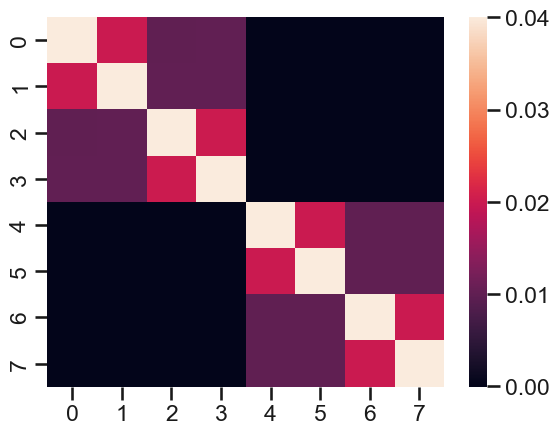

In [7]:
sns.heatmap(w2w2s['-10 Balanced'][-1])

In [8]:
def arange_svd(Y, u, vt):
    sort = np.sign(np.abs(np.round(Y.T @ vt.T)))
    idxs = np.where(sort == 1)[1]
    u = u @ sort.T
    sgn = np.diag(np.sign(np.sum(u, axis=0)))
    u = sgn.T @ u
    vt = sort @ vt
    vt = sgn @ vt
    return u, vt



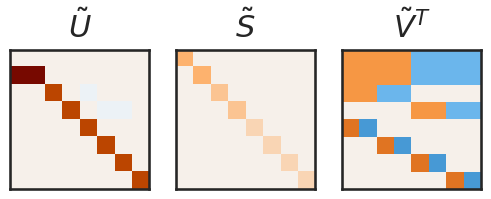

In [11]:
sigma_yx = 1./8. * Y.T @ X
U, S, VT = np.linalg.svd(sigma_yx, False)
U, VT = arange_svd(Y, U, VT)

max_val = np.max([U, np.diag(S), VT]) * 1.05

fig, axs = plt.subplots(1, 3, figsize=(5.25, 2.5))
axs[0].imshow(U, cmap=div_cmap, vmin=-max_val, vmax=max_val)
axs[1].imshow(np.diag(S), cmap=div_cmap, vmin=-max_val, vmax=max_val)
axs[2].imshow(VT, cmap=div_cmap, vmin=-max_val, vmax=max_val)
for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
axs[0].set_title("$\\tilde{U}$", pad=9., fontsize=22)
axs[1].set_title("$\\tilde{S}$", pad=9., fontsize=22)
axs[2].set_title("$\\tilde{V}^T$", pad=9., fontsize=22)

fig.tight_layout()

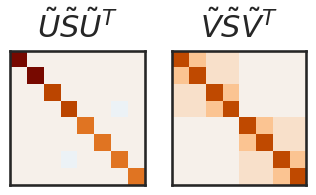

In [12]:
sigma_yx = 1./8. * Y.T @ X
U, S, VT = np.linalg.svd(sigma_yx, False)

max_val = np.max([np.max(U@np.diag(S)@U.T), np.max(VT.T@np.diag(S)@VT)]) * 1.05

fig, axs = plt.subplots(1, 2, figsize=(3.5, 2.5))
axs[0].imshow(U@np.diag(S)@U.T, cmap=div_cmap, vmin=-max_val, vmax=max_val)
axs[1].imshow(VT.T@np.diag(S)@VT, cmap=div_cmap, vmin=-max_val, vmax=max_val)
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
axs[0].set_title("$\\tilde{U}\\tilde{S}\\tilde{U}^T$", pad=9., fontsize=22)
axs[1].set_title("$\\tilde{V}\\tilde{S}\\tilde{V}^T$", pad=9., fontsize=22)

fig.tight_layout()

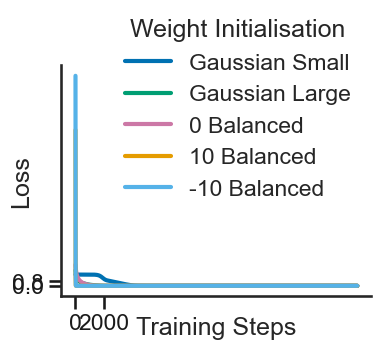

In [16]:


labels = initial_weight_pairs.keys()
colours = [blind_colours[i+1] for i in range(len(labels))]
fig, ax = plt.subplots(figsize=(4., 3.))
for i, init in enumerate(initial_weight_pairs.keys()):
    ax.plot(losses[init], lw=3., color=colours[i], label=init)
ax.legend(loc=(.175, 0.38), title="Weight Initialisation", frameon=False)
ax.set_xlabel("Training Steps", labelpad=-12)
ax.set_ylabel("Loss", labelpad=-15)
ax.set_xticks([0, 2000])
ax.set_yticks([0, 0.8])
sns.despine()

FileNotFoundError: [Errno 2] No such file or directory: './figures/figure-3_c-d-e.svg'

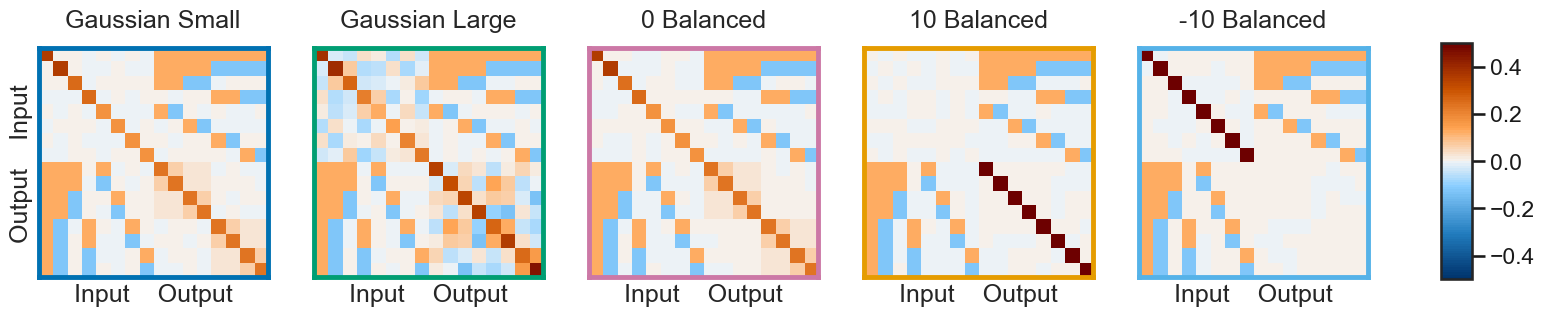

In [18]:
fig, axs = plt.subplots(1, 5, figsize=(11*5/3, 3.5), sharex=True, sharey=True)
for i, label in enumerate(labels):
    qqt = np.vstack([
        np.hstack([w1w1s[label][-1], ws[label][-1].T]),
        np.hstack([ws[label][-1], w2w2s[label][-1]])
    ])
    vals = axs[i].matshow(1./8. * qqt, cmap=div_cmap, vmin=-1./8. * 4, vmax=1./8. * 4)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(label, pad=15.)

for ax in axs:
    ax.set_xlabel("Input    Output")
axs[0].set_ylabel("Output    Input")
    
for ax, c in zip(axs, colours):
    for spine in ax.spines.values():
        spine.set_edgecolor(c)
        spine.set_linewidth(3.5)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.89, 0.1625, 0.017, 0.675])
cbar = fig.colorbar(vals, cax=cbar_ax)
# cbar.ax.set_yticks([-0.4, 0., 0.4])
fig.savefig("./figures/figure-3_c-d-e.svg")

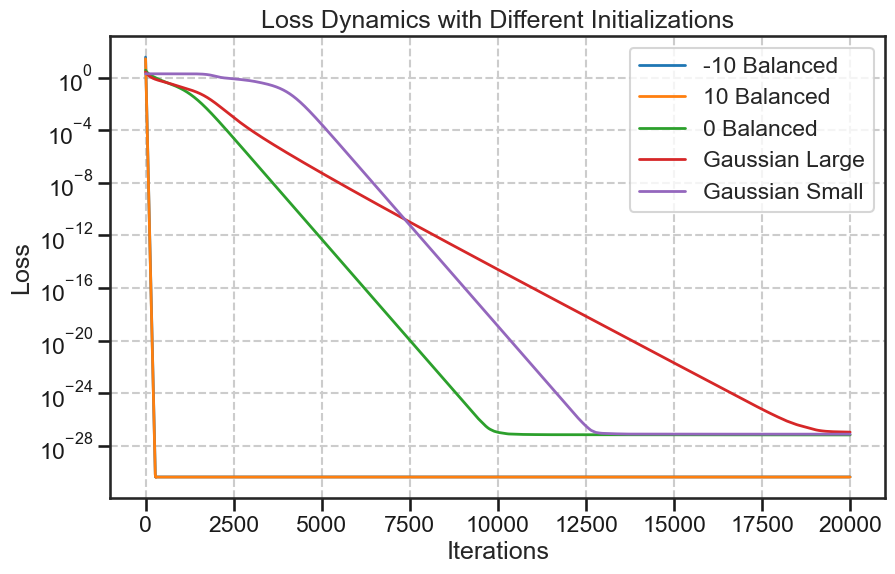

In [20]:
# Assuming losses is a dictionary containing the loss data
plt.figure(figsize=(10, 6))

# Plot each initialization with increased line width
plt.plot(losses['-10 Balanced'], label='-10 Balanced', linewidth=2)
plt.plot(losses['10 Balanced'], label='10 Balanced', linewidth=2)
plt.plot(losses['0 Balanced'], label='0 Balanced', linewidth=2)
plt.plot(losses['Gaussian Large'], label='Gaussian Large', linewidth=2)
plt.plot(losses['Gaussian Small'], label='Gaussian Small', linewidth=2)

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add titles and labels
plt.title('Loss Dynamics with Different Initializations')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Add grid lines
plt.grid(True, which="both", ls="--")

# Adjust legend location
plt.legend(loc='upper right')

# Show the plot
plt.show()

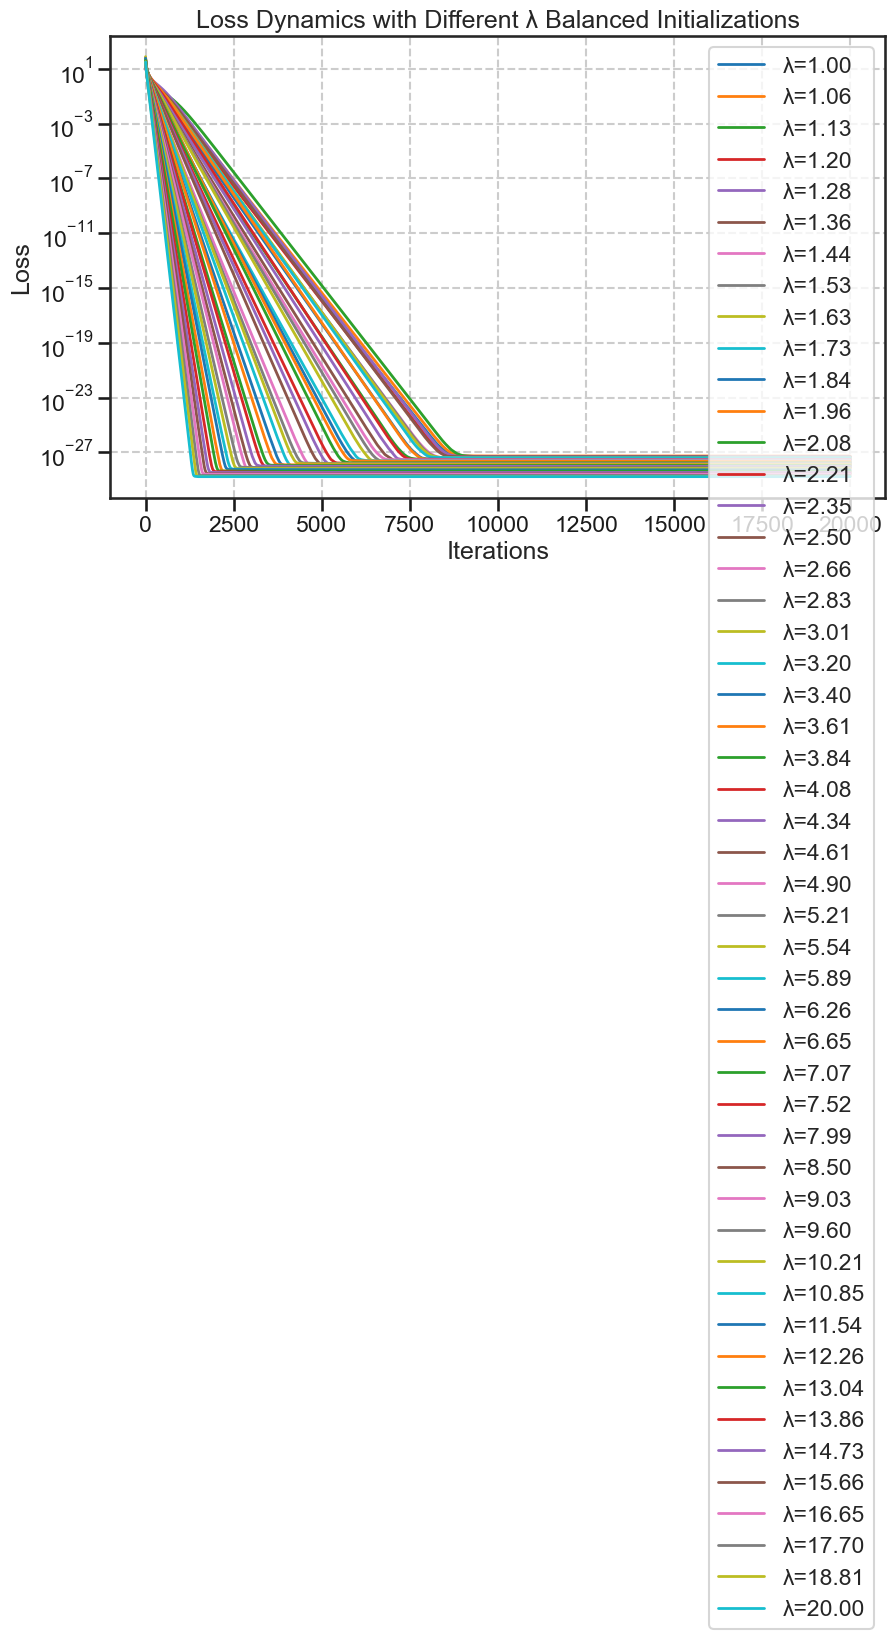

In [21]:
lambda_values = np.logspace(np.log10(1), np.log10(20), 50)

# Initialize dictionaries to store results
ws = dict()
w1w1s = dict()
w2w2s = dict()
losses = dict()
convergence_steps = []
w1_norms = []
w2_norms = []

# Convergence threshold (example value, adjust as necessary)
convergence_threshold = 1e-3

# Iterate over each λ value
for lambda_val in lambda_values:
    # Generate λ balanced weights
    init_w1_lambda_balanced, init_w2_lambda_balanced = get_lambda_balanced(lambda_val, in_dim, hidden_dim, out_dim)
    initial_weight_pairs = (init_w1_lambda_balanced, init_w2_lambda_balanced)
    
    # Initialize the model with these weights
    model = LinearNetwork(in_dim, hidden_dim, out_dim, init_w1_lambda_balanced.copy(), init_w2_lambda_balanced.copy())
    
    # Train the model and record the number of steps taken to converge
    w1s, w2s, loss_history = model.train(X, Y, training_steps, learning_rate)
    
    for step, loss in enumerate(loss_history):
        if loss < convergence_threshold:
            convergence_steps.append(step)
            break
    else:
        convergence_steps.append(training_steps)
    
    # Store the results
    ws[f'λ={lambda_val:.2f}'] = [w2 @ w1 for (w1, w2) in zip(w1s, w2s)]
    w1w1s[f'λ={lambda_val:.2f}'] = [w1.T @ w1 for w1 in w1s]
    w2w2s[f'λ={lambda_val:.2f}'] = [w2 @ w2.T for w2 in w2s]
    losses[f'λ={lambda_val:.2f}'] = [1/(2*8) * np.linalg.norm(w2 @ w1 @ X - Y)**2 for (w1, w2) in zip(w1s, w2s)]
    
    # Calculate and record the norms
    w1_norm = np.linalg.norm(w1w1s[f'λ={lambda_val:.2f}'][-1] - np.abs(lambda_val) * np.eye(in_dim))**2
    w2_norm = np.linalg.norm(w2w2s[f'λ={lambda_val:.2f}'][-1] - np.abs(lambda_val) * np.eye(in_dim))**2
    w1_norms.append(w1_norm)
    w2_norms.append(w2_norm)

# Plot the loss dynamics for each λ value
plt.figure(figsize=(10, 6))
for key in losses.keys():
    plt.plot(losses[key], label=key, linewidth=2)

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add titles and labels
plt.title('Loss Dynamics with Different λ Balanced Initializations')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Add grid lines
plt.grid(True, which="both", ls="--")

# Adjust legend location
plt.legend(loc='upper right')

# Show the plot
plt.show()

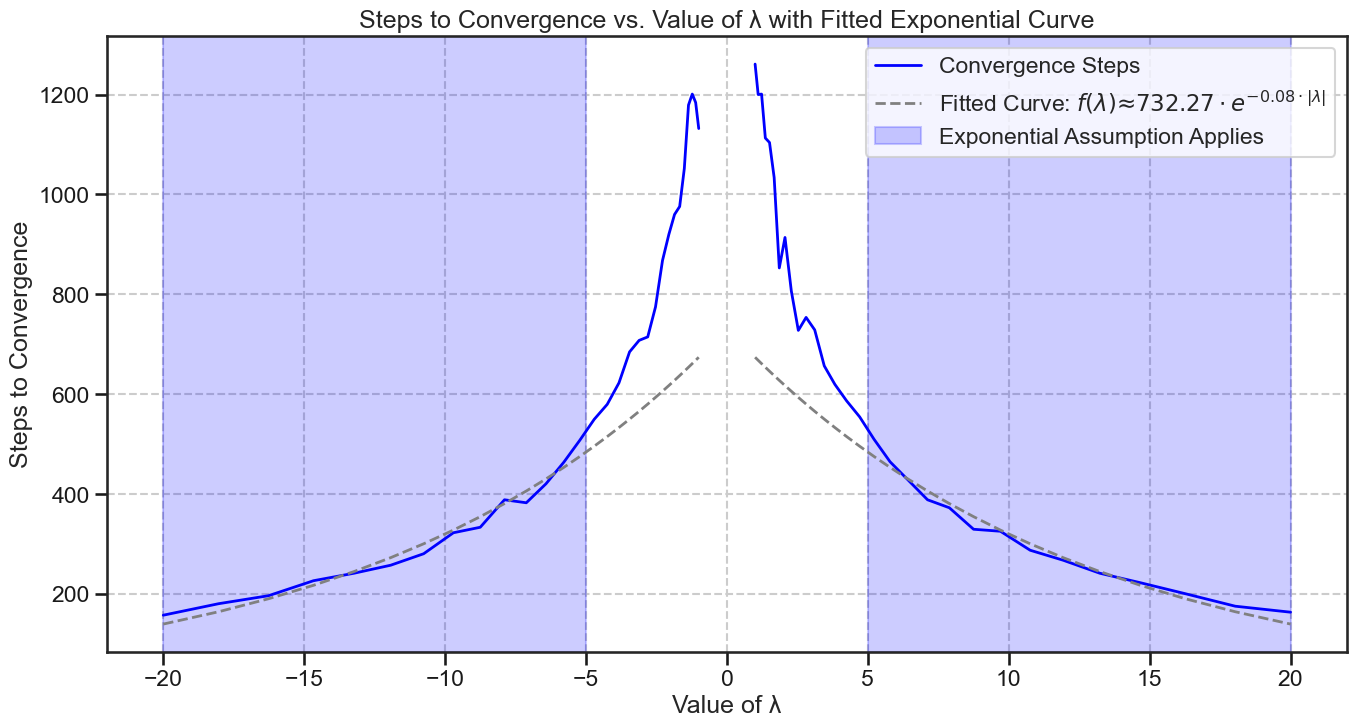

The values of the parameters are: a = -0.083, b = 7.3e+02


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Generate 25 values of λ from -20 to -1 and 25 values of λ from 1 to 20, excluding 0
lambda_values_negative = -np.logspace(np.log10(1), np.log10(20), 30)
lambda_values_positive = np.logspace(np.log10(1), np.log10(20), 30)
lambda_values = np.concatenate((lambda_values_negative, lambda_values_positive))

# Initialize dictionaries to store results
ws = dict()
w1w1s = dict()
w2w2s = dict()
losses = dict()
convergence_steps = []
w1_finals = []
w2_finals = []

# Convergence threshold (example value, adjust as necessary)
convergence_threshold = 1e-3

# Iterate over each λ value
for lambda_val in lambda_values:
    # Generate λ balanced weights
    init_w1_lambda_balanced, init_w2_lambda_balanced = get_lambda_balanced(lambda_val, in_dim, hidden_dim, out_dim)
    initial_weight_pairs = (init_w1_lambda_balanced, init_w2_lambda_balanced)
    
    # Initialize the model with these weights
    model = LinearNetwork(in_dim, hidden_dim, out_dim, init_w1_lambda_balanced.copy(), init_w2_lambda_balanced.copy())
    
    # Train the model and record the number of steps taken to converge
    w1s, w2s, loss_history = model.train(X, Y, training_steps, learning_rate)
    
    converged = False
    for step, loss in enumerate(loss_history):
        if loss < convergence_threshold:
            convergence_steps.append(step)
            converged = True
            break
    if not converged:
        convergence_steps.append(training_steps)
    
    # Store the results
    ws[f'λ={lambda_val:.2f}'] = [w2 @ w1 for (w1, w2) in zip(w1s, w2s)]
    w1w1s[f'λ={lambda_val:.2f}'] = [w1.T @ w1 for w1 in w1s]
    w2w2s[f'λ={lambda_val:.2f}'] = [w2 @ w2.T for w2 in w2s]
    losses[f'λ={lambda_val:.2f}'] = [1/(2*8) * np.linalg.norm(w2 @ w1 @ X - Y)**2 for (w1, w2) in zip(w1s, w2s)]
    
    # Calculate and record the norms
    w1_final = w1w1s[f'λ={lambda_val:.2f}'][-1]
    w2_final = w2w2s[f'λ={lambda_val:.2f}'][-1]
    w1_finals.append(w1_final)
    w2_finals.append(w2_final)

# Create pairs of (convergence_steps, λ)
convergence_lambda_pairs = list(zip(convergence_steps, lambda_values))

# Sort the pairs by λ
convergence_lambda_pairs.sort(key=lambda pair: pair[1])

# Separate the sorted pairs into negative and positive λ values
negative_pairs = [pair for pair in convergence_lambda_pairs if pair[1] < 0]
positive_pairs = [pair for pair in convergence_lambda_pairs if pair[1] > 0]

# Unpack the sorted pairs
neg_convergence_steps, neg_lambda_values = zip(*negative_pairs)
pos_convergence_steps, pos_lambda_values = zip(*positive_pairs)

# Filter the pairs for λ > 5 or λ < -5 for fitting
filtered_pairs = [(steps, λ) for steps, λ in convergence_lambda_pairs if λ > 5 or λ < -5]

# Unpack the filtered pairs
filtered_convergence_steps, filtered_lambda_values = zip(*filtered_pairs)

# Define the fitting function
def fitting_function(x, a, b):
    return b * np.exp(a * np.abs(x))

# Fit the function to the filtered data
popt, pcov = curve_fit(fitting_function, filtered_lambda_values, filtered_convergence_steps)
a, b = popt

# Generate points for the fitted curves
neg_fitted_curve = fitting_function(np.array(neg_lambda_values), a, b)
pos_fitted_curve = fitting_function(np.array(pos_lambda_values), a, b)

# Plot the sorted convergence steps for each λ value
plt.figure(figsize=(16, 8))  # Make the figure wider
plt.plot(neg_lambda_values, neg_convergence_steps, label='Convergence Steps', color='blue', linewidth=2)
plt.plot(pos_lambda_values, pos_convergence_steps, color='blue', linewidth=2)

# Plot the fitted curves separately with the same color and only one legend
plt.plot(neg_lambda_values, neg_fitted_curve, color='grey', linestyle='--', linewidth=2)
plt.plot(pos_lambda_values, pos_fitted_curve, color='grey', linestyle='--', linewidth=2, label=f'Fitted Curve: $f(λ) ≈ {b:.2f} \cdot e^{{{a:.2f} \cdot |λ|}}$')

# Shade the regions λ > 5 and λ < -5
plt.axvspan(-20, -5, color='blue', alpha=0.2, label='Exponential Assumption Applies')
plt.axvspan(5, 20, color='blue', alpha=0.2)

# Add titles and labels
plt.title('Steps to Convergence vs. Value of λ with Fitted Exponential Curve')
plt.xlabel('Value of λ')
plt.ylabel('Steps to Convergence')

# Add grid lines
plt.grid(True, which="both", ls="--")

# Add legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

# Print the values of a and b
print(f'The values of the parameters are: a = {a:.2g}, b = {b:.2g}')


In [24]:
def cosine_similarity(A, B):
    # Flatten the matrices into vectors
    vec_A = A.flatten()
    vec_B = B.flatten()
    
    # Compute the dot product and norms
    dot_product = np.dot(vec_A, vec_B)
    norm_A = np.linalg.norm(vec_A)
    norm_B = np.linalg.norm(vec_B)
    
    # Compute cosine similarity
    similarity = dot_product / (norm_A * norm_B)
    
    return similarity

In [25]:
def normalize_matrix(M):
    """
    Normalize the matrix M so that the sum of the squares of its singular values is 1.
    """
    norm_factor = np.sqrt(np.sum(np.linalg.svd(M, compute_uv=False)**2))
    return M / norm_factor

def matrix_similarity(A, B):
    """
    Compute a similarity score between matrices A and B that is invariant to squaring of singular values.
    
    Parameters:
    A, B (np.ndarray): Input matrices.
    
    Returns:
    float: Similarity score.
    """
    # Normalize the matrices
    A_norm = normalize_matrix(A)
    B_norm = normalize_matrix(B)
    
    # Compute the Frobenius norm of the difference
    frobenius_norm_diff = np.linalg.norm(A_norm - B_norm, 'fro')
    
    # Convert to a similarity score (1 - normalized difference)
    similarity = 1 - frobenius_norm_diff / np.sqrt(np.prod(A.shape))
    return similarity

In [26]:
w1w1s['λ=-1.00'][-1]

array([[ 3.36983643e+00,  2.10493343e-04,  1.80258497e-03,
        -1.77199264e-03, -1.54203777e-03,  3.51271522e-03,
         4.01954030e-04, -8.12947824e-04],
       [ 2.10493343e-04,  3.37279646e+00,  1.95825637e-03,
         2.51032126e-03,  2.16442762e-03,  2.15826642e-04,
        -3.16438034e-04,  1.40364551e-03],
       [ 1.80258497e-03,  1.95825637e-03,  2.55702180e+00,
        -6.57979243e-04, -3.77501112e-04,  5.46690202e-04,
        -1.81158175e-03, -2.07010493e-04],
       [-1.77199264e-03,  2.51032126e-03, -6.57979243e-04,
         2.55455748e+00, -2.62855257e-03, -6.49949784e-05,
         7.55545643e-04, -8.83479805e-04],
       [-1.54203777e-03,  2.16442762e-03, -3.77501112e-04,
        -2.62855257e-03,  1.99810428e+00, -4.53910392e-05,
        -1.32026247e-03, -1.59578563e-03],
       [ 3.51271522e-03,  2.15826642e-04,  5.46690202e-04,
        -6.49949784e-05, -4.53910392e-05,  1.99754409e+00,
         8.52626447e-04,  2.34181737e-04],
       [ 4.01954030e-04, -3.164380

In [27]:
task_specific_w2 = VT.T @ np.diag(S**2) @ VT
task_specific_w1 = U @ np.diag(S**2) @ U.T

task_specific_w2_0 = VT.T @ np.diag(S) @ VT
task_specific_w1_0 = U @ np.diag(S) @ U.T


w1w1s_final = {key: value[-1] for key, value in w1w1s.items()}
w2w2s_final = {key: value[-1] for key, value in w2w2s.items()}

task_specificness_w1 = {key: max(cosine_similarity(value, task_specific_w1), cosine_similarity(value, task_specific_w1_0)) for key, value in w1w1s_final.items()}
task_specificness_w2 = {key: max(cosine_similarity(value, task_specific_w2), cosine_similarity(value, task_specific_w2_0)) for key, value in w2w2s_final.items()}




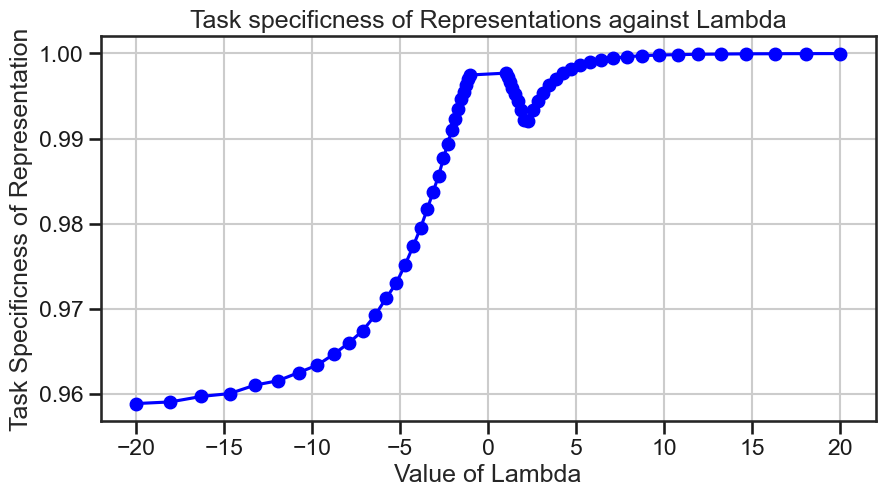

In [30]:
numeric_keys = sorted([float(key.split('=')[1].strip()) for key in task_specificness_w1.keys()])

original_key_mapping = {float(key.split('=')[1].strip()): key for key in task_specificness_w1.keys()}

values = [task_specificness_w1[original_key_mapping[key]] for key in numeric_keys]

plt.figure(figsize=(10, 5))
plt.plot(numeric_keys, values, marker='o', linestyle='-', color='b')
plt.xlabel('Value of Lambda')
plt.ylabel('Task Specificness of Representation')
plt.title('Task specificness of Representations against Lambda')
plt.grid(True)
plt.show()

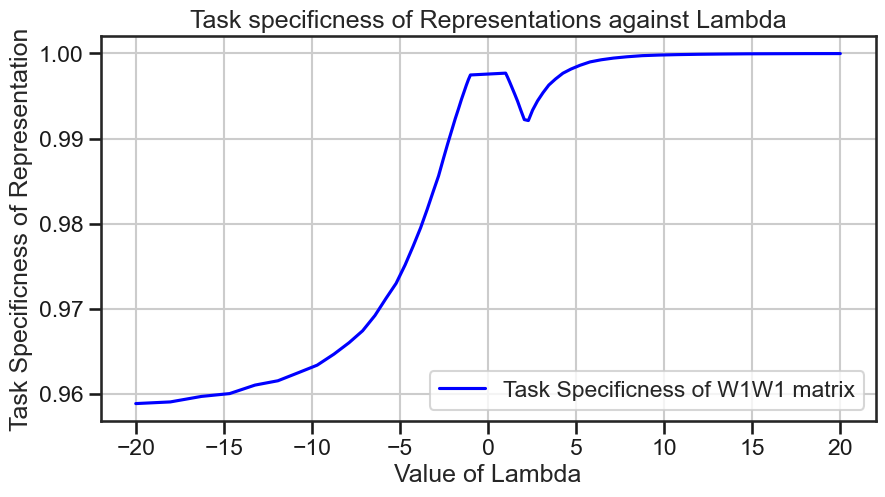

In [31]:
# Extract and sort numeric keys
numeric_keys = sorted([float(key.split('=')[1].strip()) for key in task_specificness_w1.keys()])

# Map numeric keys back to original keys
original_key_mapping = {float(key.split('=')[1].strip()): key for key in task_specificness_w1.keys()}

# Extract values based on sorted keys
values = [task_specificness_w1[original_key_mapping[key]] for key in numeric_keys]

# Create a line plot without markers
plt.figure(figsize=(10, 5))
plt.plot(numeric_keys, values, linestyle='-', color='b', label='Task Specificness of W1W1 matrix')
plt.xlabel('Value of Lambda')
plt.ylabel('Task Specificness of Representation')
plt.title('Task specificness of Representations against Lambda')
plt.grid(True)
plt.legend()
plt.show()

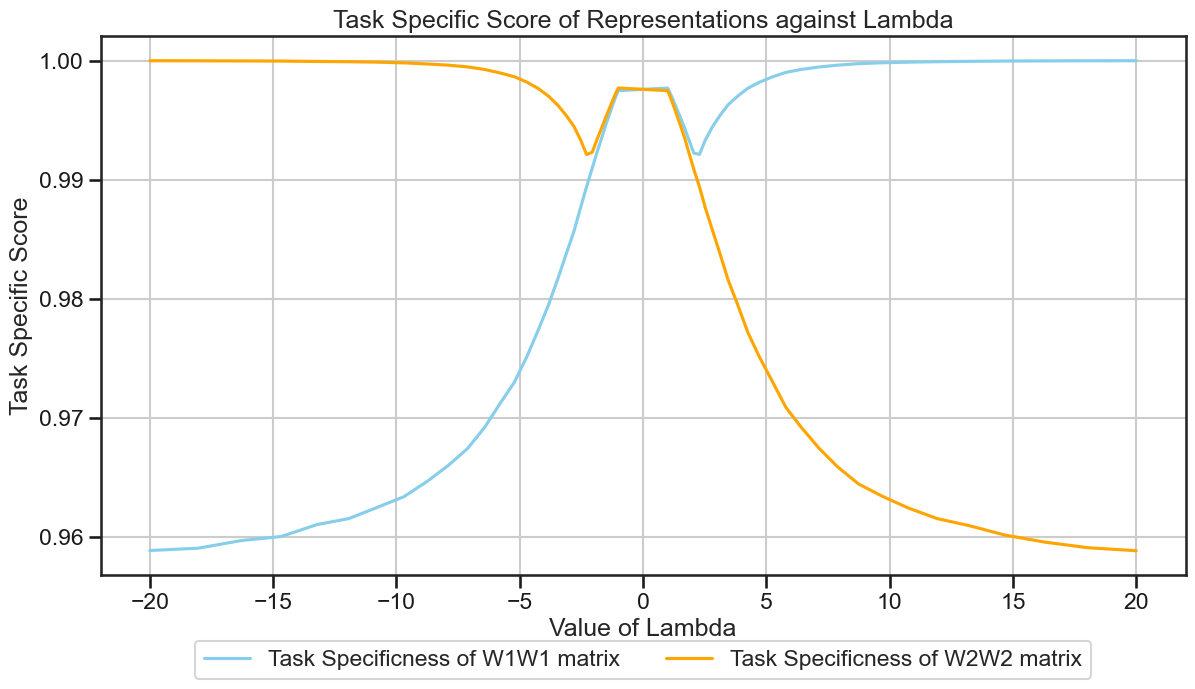

In [32]:
numeric_keys = sorted([float(key.split('=')[1].strip()) for key in task_specificness_w1.keys()])

original_key_mapping = {float(key.split('=')[1].strip()): key for key in task_specificness_w1.keys()}

values_w1 = [task_specificness_w1[original_key_mapping[key]] for key in numeric_keys]

values_w2 = [task_specificness_w2[original_key_mapping[key]] for key in numeric_keys]

plt.figure(figsize=(14, 7))  # Larger figure size

plt.plot(numeric_keys, values_w1, linestyle='-', color='skyblue', label='Task Specificness of W1W1 matrix')

plt.plot(numeric_keys, values_w2, linestyle='-', color='orange', label='Task Specificness of W2W2 matrix')

plt.xlabel('Value of Lambda')
plt.ylabel('Task Specific Score')
plt.title('Task Specific Score of Representations against Lambda')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # Legend outside the plot
plt.show()